In [20]:
!pip install -q --upgrade transformers
!pip install -q datasets evaluate peft accelerate

In [12]:
# ---- 1. IMPORTS ----

import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

from datasets import load_dataset

import evaluate

from peft import LoraConfig, get_peft_model

import random
import numpy as np


In [13]:
# ---- 2. REPRODUCIBILITY ----

def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)                 # Python's built-in RNG
    np.random.seed(seed)              # NumPy RNG
    torch.manual_seed(seed)           # PyTorch CPU RNG
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # PyTorch GPU RNG


set_seed(42)

In [14]:
# ---- 3. DATA & TOKENIZER ----

# Name of the base model we will fine-tune
BASE_MODEL_NAME = "roberta-base"

# Load the SST-2 dataset from the GLUE benchmark
dataset = load_dataset("glue", "sst2")

# Load tokenizer corresponding to the base model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)


def preprocess_function(example):
    """
    Tokenize the input text for SST-2.
    Each example has a field 'sentence' and a label (0/1).
    """
    # Tokenize the sentence with truncation and padding to a fixed max length
    return tokenizer(
        example["sentence"],
        truncation=True,      # Cut off sentences longer than max_length
        padding="max_length", # Pad shorter ones to max_length for uniform shape
        max_length=128,       # 128 tokens is enough for short sentiment sentences
    )


# Apply the preprocessing to the entire dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [15]:
# ---- 4. METRICS ----

# Load ready-made accuracy and F1 scorers
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    """
    Compute metrics for evaluation.
    Hugging Face Trainer passes (logits, labels) to this function.
    """
    logits, labels = eval_pred     # Unpack predictions and true labels
    predictions = logits.argmax(axis=-1)  # Pick the class with highest logit score

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compute F1 (for binary classification, average='binary' by default)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    # Return both; Trainer will log them
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
    }

In [16]:
# ---- 5. TRAIN / EVAL DATA SPLITS ----

# Hugging Face GLUE SST-2 has 'train', 'validation', 'test' splits.
train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]

In [21]:
# ---- 6. FULL FINE-TUNING ----

def train_full_finetune():
    """
    Train the base model with FULL fine-tuning (all weights trainable).
    """
    print("=== FULL FINE-TUNING (ALL PARAMETERS TRAINABLE) ===")

    # Load the base model with a classification head for 2 labels (negative/positive)
    model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL_NAME,
        num_labels=2,
    )

    # Define training arguments for full fine-tuning
    training_args = TrainingArguments(
        output_dir="./results_full_ft",      # Where to save logs + checkpoints
        eval_strategy="epoch",         # Run evaluation at the end of each epoch
        save_strategy="epoch",               # Save a checkpoint at the end of each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,                   # Regularization to avoid overfitting
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",    # Use accuracy to pick best model
        greater_is_better=True,              # Higher accuracy is better
        save_total_limit=2,                  # Only keep the last 2 checkpoints
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,                 # Tokenizer (for saving, etc.)
        compute_metrics=compute_metrics,     # Function to compute metrics
    )


    trainer.train()

    eval_results = trainer.evaluate()
    print("Full FT eval results:", eval_results)

    # Save the final model and tokenizer
    trainer.save_model("./results_full_ft/final_model")
    tokenizer.save_pretrained("./results_full_ft/final_model")

    return eval_results

In [22]:
# ---- 7. LoRA FINE-TUNING ----

def train_lora_finetune():
    """
    Train the base model using LoRA (only small adapter weights trainable).
    """
    print("=== LoRA FINE-TUNING (PARAMETER-EFFICIENT) ===")

    # Load the same base model architecture
    base_model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL_NAME,
        num_labels=2,
    )

    # Define a LoRA configuration
    lora_config = LoraConfig(
        r=8,                         # Rank of LoRA matrices (small = fewer params)
        lora_alpha=16,               # Scaling factor for LoRA updates
        lora_dropout=0.1,
        bias="none",                 # Don't train biases (only LoRA params)
        task_type="SEQ_CLS",
    )

    # Wrap the base model with PEFT to inject LoRA adapters
    lora_model = get_peft_model(base_model, lora_config)


    lora_model.print_trainable_parameters()

    # Define training arguments for LoRA fine-tuning
    training_args = TrainingArguments(
        output_dir="./results_lora",         # Output directory for LoRA run
        eval_strategy="epoch",         # Evaluate each epoch
        save_strategy="epoch",               # Save LoRA checkpoints each epoch
        learning_rate=1e-4,                  # LoRA often tolerates higher LR
        per_device_train_batch_size=16,      # Keep similar batch size for fairness
        per_device_eval_batch_size=32,
        num_train_epochs=3,                  # Same number of epochs as full FT
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        save_total_limit=2,
    )

    # Trainer with the LoRA-wrapped model
    trainer = Trainer(
        model=lora_model,                    # LoRA model
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train LoRA adapters
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print("LoRA eval results:", eval_results)

    # Save only the LoRA adapter weights
    lora_model.save_pretrained("./results_lora/final_adapter")
    tokenizer.save_pretrained("./results_lora/final_adapter")

    return eval_results

In [23]:
full_results = train_full_finetune()
lora_results = train_lora_finetune()

print("\n=== COMPARISON SUMMARY ===")
print("Full FT:", full_results)
print("LoRA:", lora_results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== FULL FINE-TUNING (ALL PARAMETERS TRAINABLE) ===


/tmp/ipython-input-3485862858.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.196800,0.225126,0.941514,0.942111
2,0.099700,0.255164,0.941514,0.943522
3,0.116200,0.268360,0.947248,0.948198


Full FT eval results: {'eval_loss': 0.26836010813713074, 'eval_accuracy': 0.9472477064220184, 'eval_f1': 0.9481981981981982, 'eval_runtime': 5.2646, 'eval_samples_per_second': 165.634, 'eval_steps_per_second': 5.319, 'epoch': 3.0}
=== LoRA FINE-TUNING (PARAMETER-EFFICIENT) ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2314895152.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.229200,0.204093,0.932339,0.934078
2,0.188000,0.213395,0.936927,0.938957
3,0.225900,0.214064,0.936927,0.938133


LoRA eval results: {'eval_loss': 0.21339534223079681, 'eval_accuracy': 0.9369266055045872, 'eval_f1': 0.9389567147613762, 'eval_runtime': 5.5286, 'eval_samples_per_second': 157.726, 'eval_steps_per_second': 5.065, 'epoch': 3.0}

=== COMPARISON SUMMARY ===
Full FT: {'eval_loss': 0.26836010813713074, 'eval_accuracy': 0.9472477064220184, 'eval_f1': 0.9481981981981982, 'eval_runtime': 5.2646, 'eval_samples_per_second': 165.634, 'eval_steps_per_second': 5.319, 'epoch': 3.0}
LoRA: {'eval_loss': 0.21339534223079681, 'eval_accuracy': 0.9369266055045872, 'eval_f1': 0.9389567147613762, 'eval_runtime': 5.5286, 'eval_samples_per_second': 157.726, 'eval_steps_per_second': 5.065, 'epoch': 3.0}


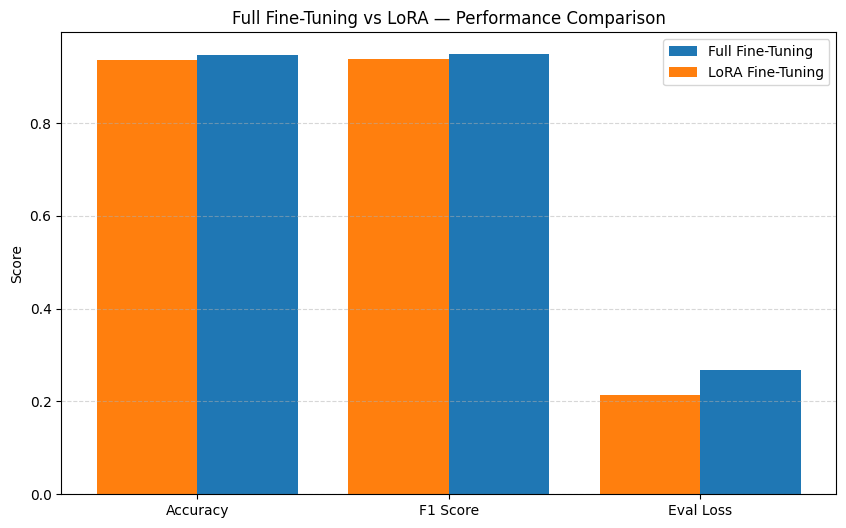

In [26]:
import matplotlib.pyplot as plt

# Metrics and values
metrics = ["Accuracy", "F1 Score", "Eval Loss"]
full_vals = [
    full_results["eval_accuracy"],
    full_results["eval_f1"],
    full_results["eval_loss"]
]
lora_vals = [
    lora_results["eval_accuracy"],
    lora_results["eval_f1"],
    lora_results["eval_loss"]
]

# Plot
plt.figure(figsize=(10,6))
x = range(len(metrics))
plt.bar(x, full_vals, width=0.4, label="Full Fine-Tuning", align="edge")
plt.bar([p - 0.4 for p in x], lora_vals, width=0.4, label="LoRA Fine-Tuning", align="edge")

# Labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Full Fine-Tuning vs LoRA — Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./results_full_ft/final_model")

# Load FULL fine-tuned model
full_model = AutoModelForSequenceClassification.from_pretrained(
    "./results_full_ft/final_model"
).to("cuda")

# Load base model + LoRA adapters
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2
).to("cuda")
lora_model = PeftModel.from_pretrained(
    base_model, "./results_lora/final_adapter"
).to("cuda")

# Utility: Predict function
def predict(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs).logits
    pred = torch.argmax(outputs, dim=-1).item()
    label = "positive" if pred == 1 else "negative"
    return label, outputs.softmax(dim=-1).cpu().tolist()[0]

# Test sentences where models might differ
test_inputs = [
    "I absolutely loved this movie, it was fantastic!",
    "The film was okay, but I expected more.",
    "This was the worst movie I have seen this year.",
    "I don't know how to feel about this movie.",
    "The acting was terrible, but the story was good.",
]

# Compare outputs
for text in test_inputs:
    full_label, full_scores = predict(full_model, text)
    lora_label, lora_scores = predict(lora_model, text)

    print("\n======================================")
    print("Input:", text)
    print("--------------------------------------")
    print("FULL FT Prediction :", full_label, "  | scores =", full_scores)
    print("LoRA Prediction    :", lora_label, "  | scores =", lora_scores)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Input: I absolutely loved this movie, it was fantastic!
--------------------------------------
FULL FT Prediction : positive   | scores = [0.00023226899793371558, 0.9997677206993103]
LoRA Prediction    : positive   | scores = [0.00046076139551587403, 0.9995392560958862]

Input: The film was okay, but I expected more.
--------------------------------------
FULL FT Prediction : positive   | scores = [0.006802287418395281, 0.9931976795196533]
LoRA Prediction    : positive   | scores = [0.2593221962451935, 0.7406778335571289]

Input: This was the worst movie I have seen this year.
--------------------------------------
FULL FT Prediction : negative   | scores = [0.9993935823440552, 0.0006063770269975066]
LoRA Prediction    : negative   | scores = [0.999128520488739, 0.0008714848663657904]

Input: I don't know how to feel about this movie.
--------------------------------------
FULL FT Prediction : negative   | scores = [0.9992042183876038, 0.0007958151982165873]
LoRA Prediction    : negat

In [29]:
!zip -r full_ft_model.zip ./results_full_ft/final_model

  adding: results_full_ft/final_model/ (stored 0%)
  adding: results_full_ft/final_model/training_args.bin (deflated 53%)
  adding: results_full_ft/final_model/tokenizer.json (deflated 82%)
  adding: results_full_ft/final_model/special_tokens_map.json (deflated 52%)
  adding: results_full_ft/final_model/model.safetensors (deflated 12%)
  adding: results_full_ft/final_model/tokenizer_config.json (deflated 75%)
  adding: results_full_ft/final_model/merges.txt (deflated 53%)
  adding: results_full_ft/final_model/config.json (deflated 50%)
  adding: results_full_ft/final_model/vocab.json (deflated 59%)


In [30]:
!zip -r lora_adapter.zip ./results_lora/final_adapter

  adding: results_lora/final_adapter/ (stored 0%)
  adding: results_lora/final_adapter/README.md (deflated 66%)
  adding: results_lora/final_adapter/tokenizer.json (deflated 82%)
  adding: results_lora/final_adapter/adapter_model.safetensors (deflated 7%)
  adding: results_lora/final_adapter/special_tokens_map.json (deflated 52%)
  adding: results_lora/final_adapter/tokenizer_config.json (deflated 75%)
  adding: results_lora/final_adapter/merges.txt (deflated 53%)
  adding: results_lora/final_adapter/vocab.json (deflated 59%)
  adding: results_lora/final_adapter/adapter_config.json (deflated 58%)
